# Filter interpretation walkthrough
**Authorship:**
Adam Klie (last updated: *07/12/2023*)
***
**Description:**
This notebook is meant to serve as a guide for interpreting the learned filters of a trained model. It includes some background on the analysis, a worked example, and a discussion of the results.
***

# Background
Filter interpretation was one of the first methods used to probe the representations learned by sequence-based genomics models. The most commonly used approach involves identifying subsequences of a set of inputs that maximally activate a given neuron in the model. These subsequences can then be used to generate a position frequency matrix (PFM), which can be visualized as a sequence logo tht we commonly derive from experimental assays. The PFMs can also be submitted to tools like TomTom for annotation with known motif databases such as JASPAR or HOCOMOCO.

# Running a filter interpretation analysis
Let's run a filter interpretation analysis on small model trained on human embryonic stem cell ChIP-seq data. 

SeqExplainer provides functions for running a step by step filter interpretation analysis from as set of sequences and a trained model to filter visualization and annotation. We will first show how to run this analysis with SeqExplainer, and then show how to use EUGENe's wrapper functions to run the same analysis with only a few commands.

In [1]:
# Load the seqexplainer package
import os
import seqexplainer

## Load in a model
 - TODO: Make the model checkpoint available somewhere

In [3]:
from eugene import models

In [5]:
# Load up the model form the checkpoint
model_file = "/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/logs/revision/kopp21/kopp21_cnn/trial_5/checkpoints/epoch=23-step=328344.ckpt"
model_arch = models.load_config(config_path="/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/configs/kopp21/kopp21_cnn.yaml")
model = models.SequenceModule.load_from_checkpoint(model_file, arch=model_arch.arch)

[rank: 0] Global seed set to 5


# Load in the data
We first need to load in sequences we will use to run the analysis. Any sequences could theoretically be used, but we will use the sequences from the test set of the model we loaded in above. These are available as a downloaded zarr store from TODO

In [8]:
# TODO: Make this dataset available
import seqdata as sd

In [9]:
# Read in the test data
sdata_test = sd.open_zarr("/cellar/users/aklie/data/eugene/revision/kopp21/kopp21_test.zarr").load()

The current version of SeqExplainer's filter interpretation functions requires that we feed the model torch tensors, so we will also convert the sequences to tensors.

In [10]:
# Load in torch
import torch

In [11]:
# Grab the seqs froma the seqdaata
seqs = sdata_test["ohe_seq"].transpose("_sequence", "_ohe", "length").to_numpy()
seqs_torch = torch.tensor(seqs, dtype=torch.float32).to(model.device)

## Get activations for test sequences
We first need to get all the activations from passing the inputs through the layer or neuron of interest. Depending on model architecture, and how the model was defined  (i.e. the way the nn.Module's init function looks), we can use different code to get the activations. We will show how to do this using EUGENe's wrapper functions first, starting by seeing what layers are available to get activations from.

In [12]:
# See what layers are available and what their names are
models.list_available_layers(model)

['arch',
 'arch.revcomp',
 'arch.conv',
 'arch.maxpool',
 'arch.batchnorm',
 'arch.conv2',
 'arch.batchnorm2',
 'arch.linear',
 'train_metric',
 'val_metric',
 'test_metric']

We can see from above that we can pull the layer outputs from the revcomp layer, the first conv layer, and the first max pool layer and so on. We typically care about the first convolutional layer, so we will grab from that one

In [13]:
# Get the first layer of the model
layer_name = "arch.conv"

In [14]:
# This is the seqexplainer function for getting the outputs from a layer
from seqexplainer import get_layer_outputs

In [15]:
# This is the seqexplainer function for getting the outputs from a layer, see the API docs for more info
activations_se = get_layer_outputs(
    model=model,
    inputs=seqs_torch,
    layer_name=layer_name,
    batch_size=32,
    device="cuda",
    verbose=True
)
activations_se.shape

Computing layer outputs for layer arch.conv on batches of size 32:   0%|          | 0/2010 [00:00<?, ?it/s]

(64309, 10, 490)

We can see from this that we have a set of activations for each sequence, kernel and position of the input sequence (ignoring the ends because we used valid padding here). This is what we want!

<div class="alert alert-block alert-danger">
Wait! There are a couple problems with what we just did. 

1. We are using the outputs from the first convolutional layer, but we are not using the activations from the first convolutional layer. If we look back at the layers that we can pull from, we can see that there is no ReLU available. It turns out, that with this particular architecture, the functional ReLU was used, meaning that we can't access it the way we would if it was defined as an nn.Module.

2. The `get_layer_outputs` function calculates the outputs all the way through the model! With this model we are passing the inputs through a revcomp layer first (which reverse complements the sequence), and then passing both the revcomp and the initial input through the model. This means that activations we grab from the output of the first convolutional layer could be from either sequence, but we don't know which! If we naively take seqlets corresponding to these activation from the forward strand, we may be missing the true seqlets that correspond to the activations from the reverse strand. This will likely cause the PFMs to generate to be very noisy (or not just completely random)
</div>

Luckily, SeqExplainer can handle this without having to write too much extra code. We just need to grab the layer from the model and directly pass sequences through (don't forget the activation!).

In [27]:
import torch.nn.functional as F

In [28]:
# We can also grab the activations directly by nabbing the layer from the model
layer = models.get_layer(model, layer_name).to("cuda")
activations = F.relu(layer(seqs_torch.to("cuda"))).detach().cpu().numpy()

And just like that we are on our way!

## Identifying maximally activating seqlets
Next we need to find where the activations are high and pull out the subsequences (of the same size as the kernel) that maximally activate each filter. We can do this using one of two functions in SeqExplainer:

In [30]:
from seqexplainer import get_activators_n_seqlets, get_activators_max_seqlets

For the purposes of this tutorial, we will focus on the first one, in which we simply choose the top n activations for each filter. Below we try out a few values of n.

In [31]:
# This first one simply grabs the top n seqlets from the activations and sequences we pass in
mas_100_seqs = get_activators_n_seqlets(
    activations=activations,
    sequences=seqs,
    kernel_size=11,
    padding=0,
    num_seqlets=100,
    num_filters=None
)

Getting filter activators for 10 filters:   0%|          | 0/10 [00:00<?, ?it/s]

In [32]:
# For comparisons sake, we can also grab 1000 and 10 seqlets to see how the results change
mas_1000_seqs = get_activators_n_seqlets(
    activations=activations,
    sequences=seqs,
    kernel_size=11,
    padding=0,
    num_seqlets=1000,
    num_filters=None
)

Getting filter activators for 10 filters:   0%|          | 0/10 [00:00<?, ?it/s]

In [33]:
mas_10_seqs = get_activators_n_seqlets(
    activations=activations,
    sequences=seqs,
    kernel_size=11,
    padding=0,
    num_seqlets=10,
    num_filters=None
)

Getting filter activators for 10 filters:   0%|          | 0/10 [00:00<?, ?it/s]

## Creating position frequency matrices (PFMs)
Now that we have the maximally activating subsequences, we can create a position frequency matrix (PFM) for each filter. We can do this using the following function:

In [34]:
# This function simply stacks the activatiors on top of each other and counts up the number of times each base is present
from seqexplainer import get_pfms

In [35]:
mas_100_pfms = get_pfms(
    filter_activators=mas_100_seqs,
    kernel_size=11
)

mas_1000_pfms = get_pfms(
    filter_activators=mas_1000_seqs,
    kernel_size=11
)

mas_10_pfms = get_pfms(
    filter_activators=mas_10_seqs,
    kernel_size=11
)

## Visualizing the PFMs as a sequence logos
We can now visualize the PFMs as sequence logos using logomaker. We can do this using the following function:

In [36]:
from seqexplainer._plot import plot_filter_logos

Matplotlib is building the font cache; this may take a moment.


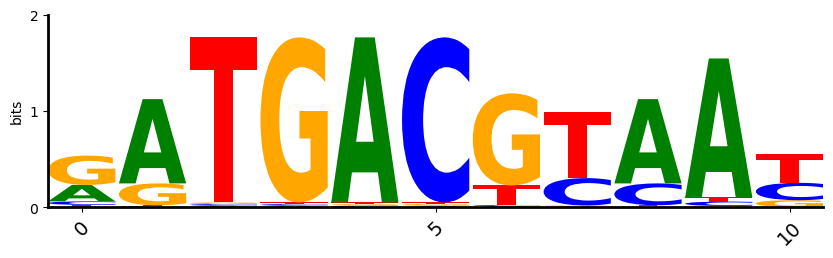

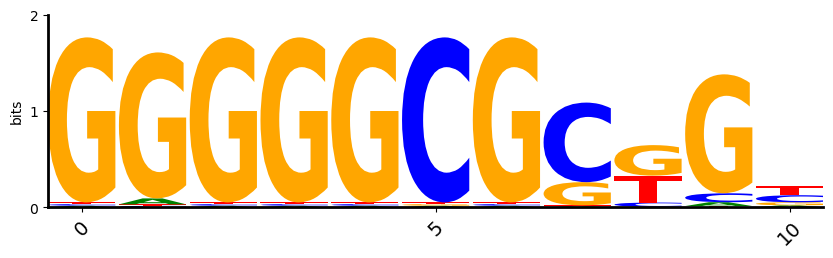

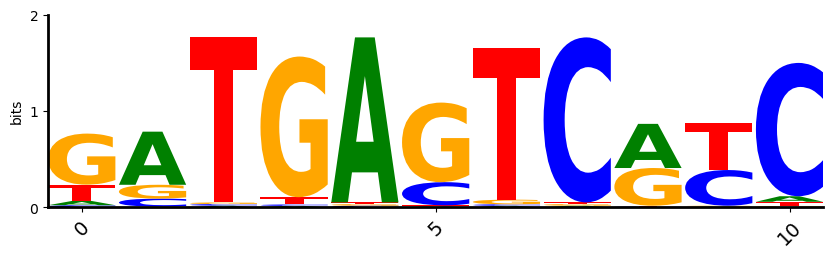

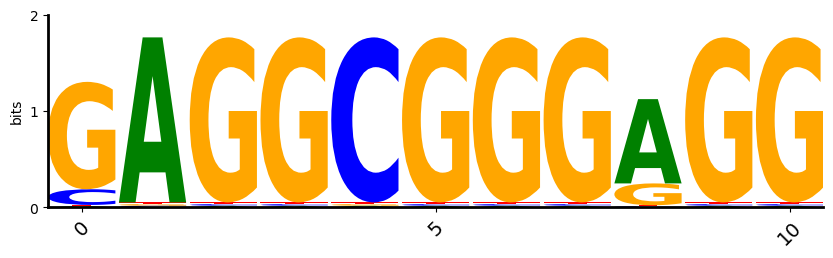

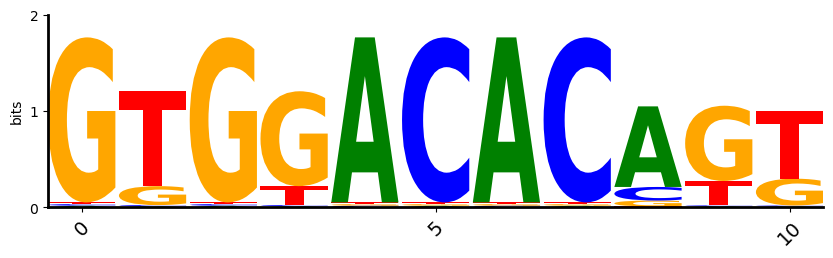

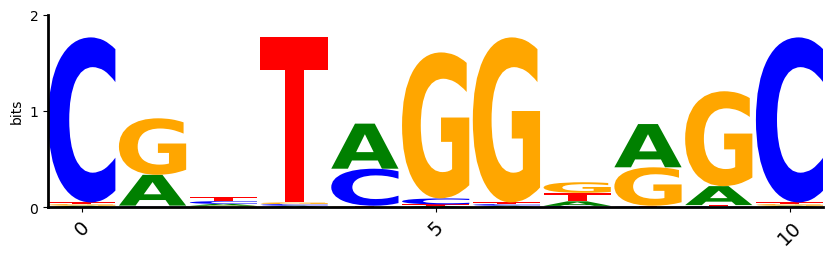

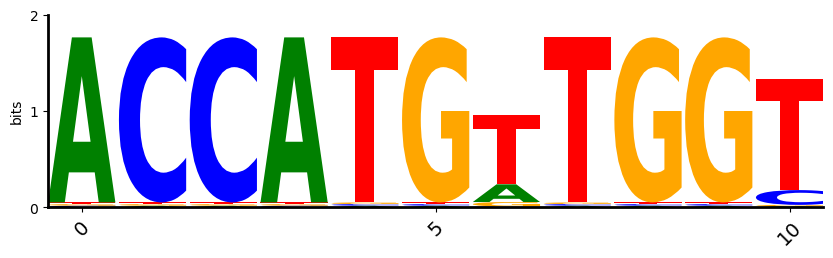

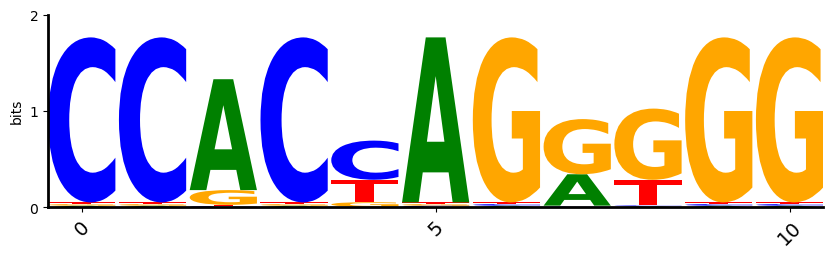

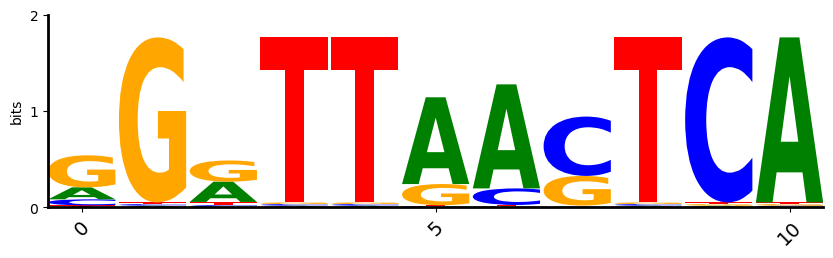

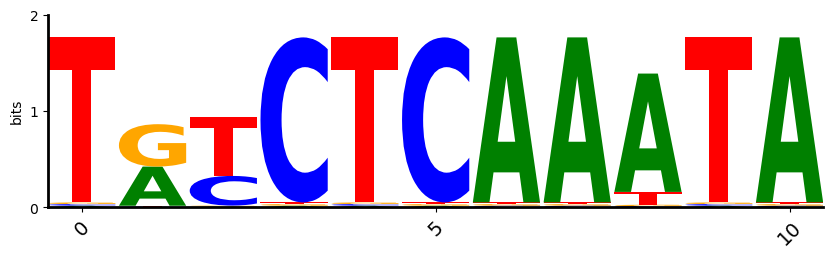

In [37]:
plot_filter_logos(
    mtxs=mas_100_pfms
)

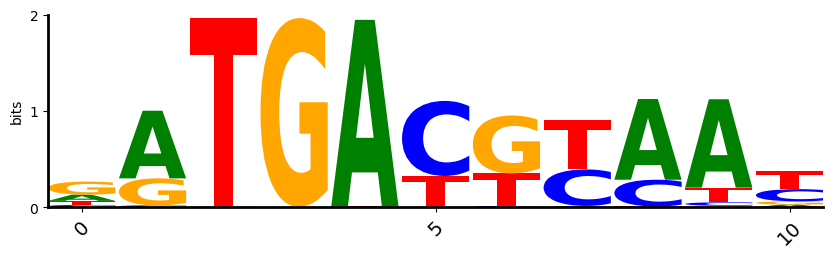

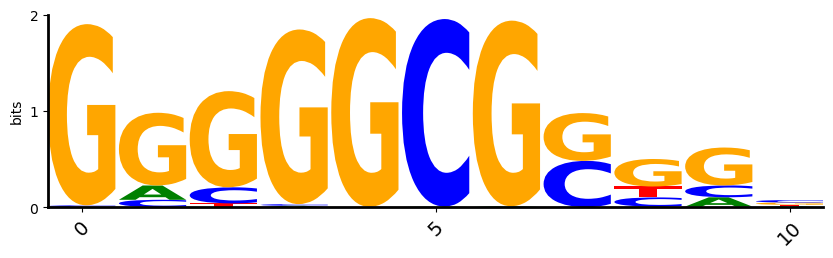

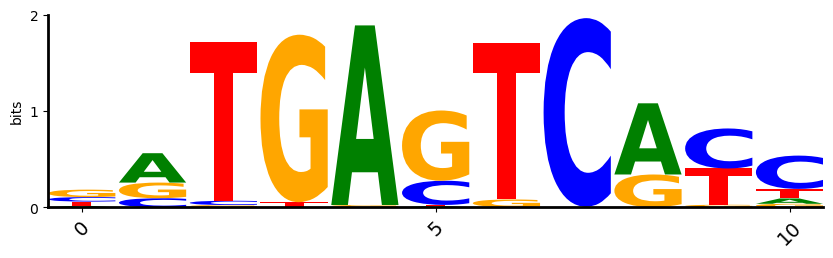

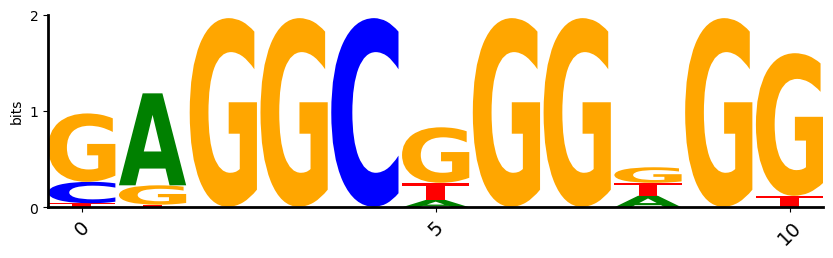

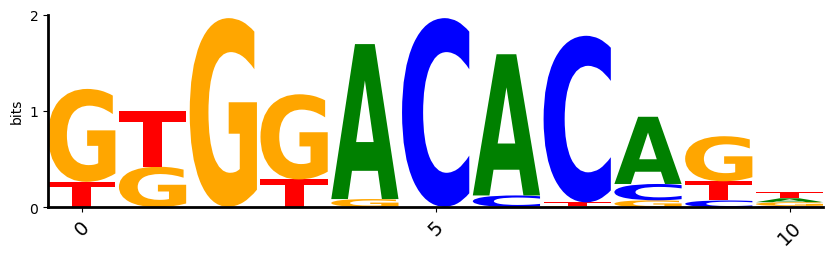

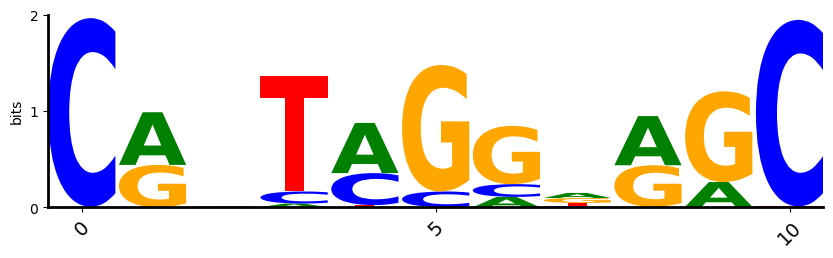

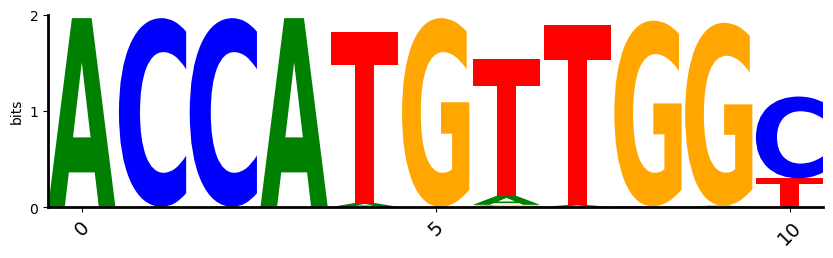

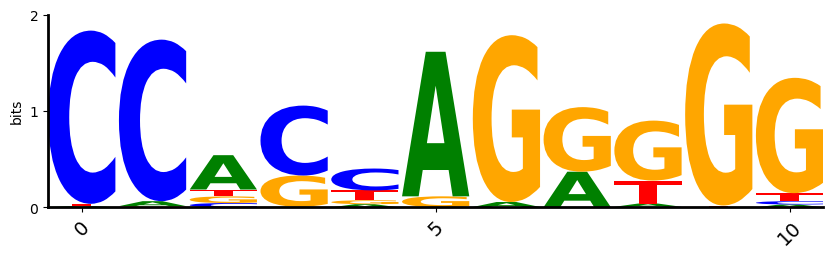

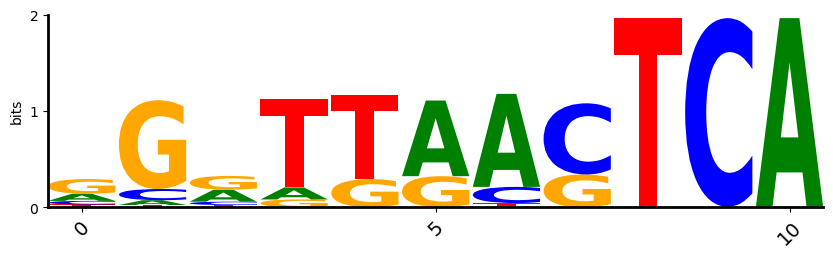

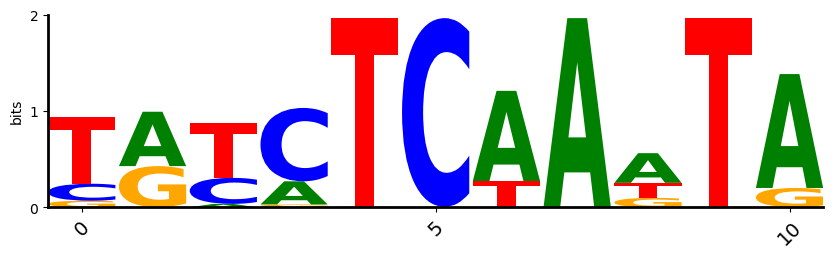

In [38]:
plot_filter_logos(
    mtxs=mas_1000_pfms
)

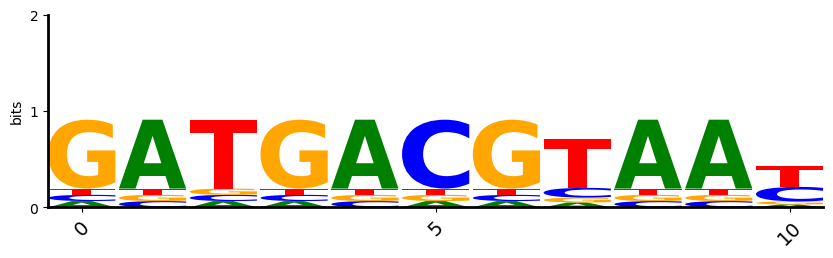

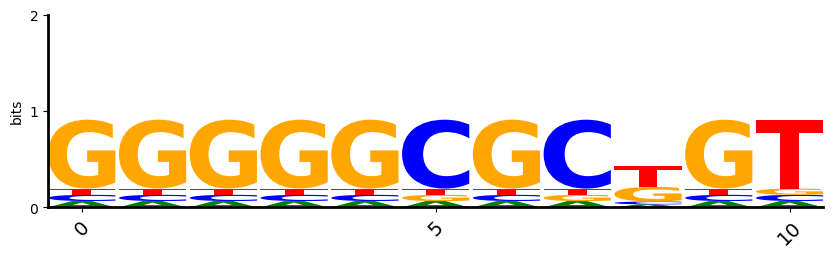

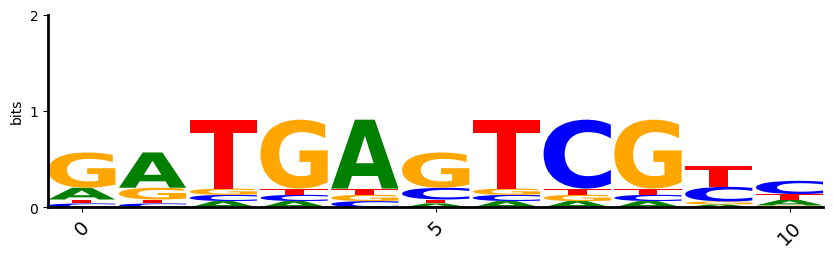

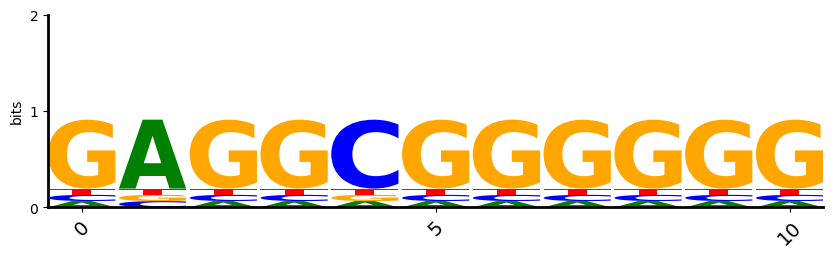

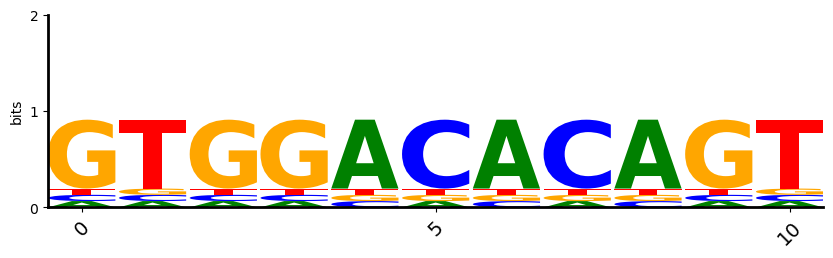

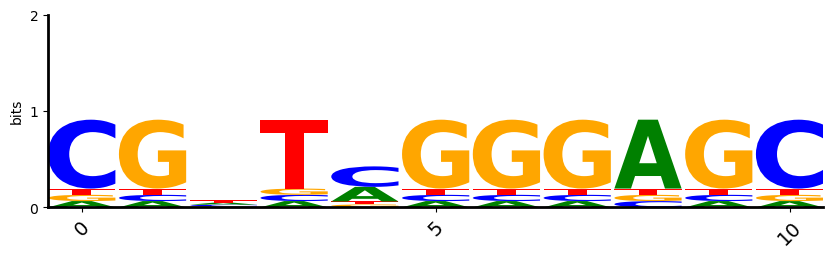

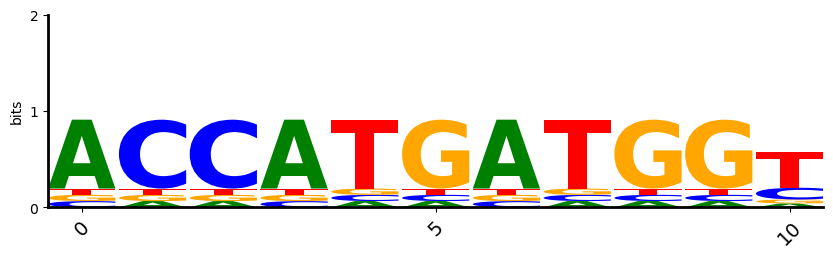

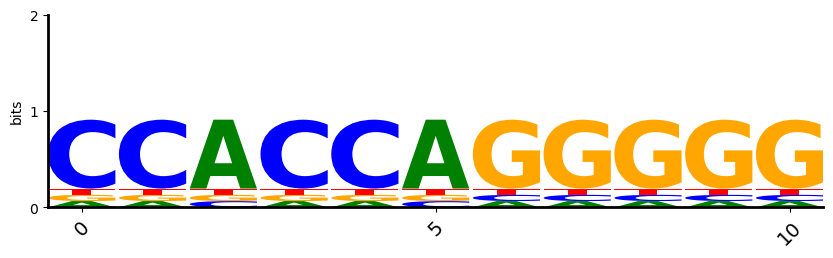

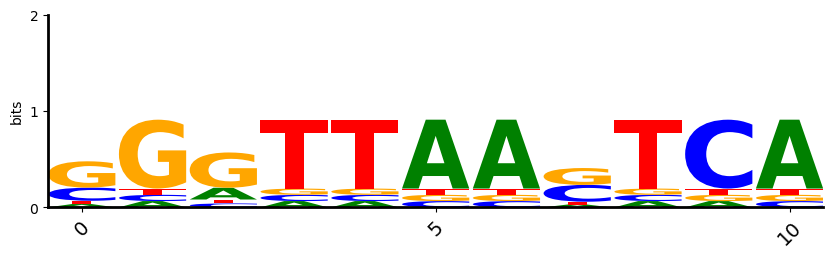

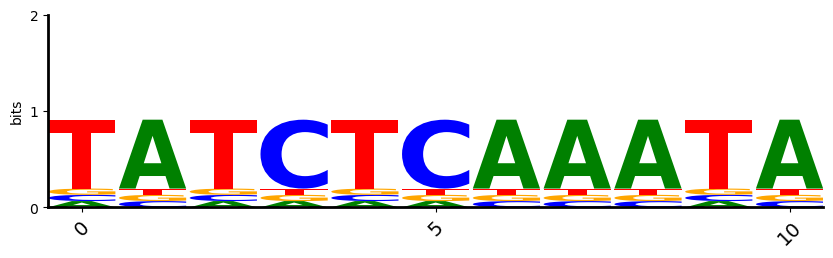

In [39]:
plot_filter_logos(
    mtxs=mas_10_pfms
)

We can see from above that we get noisier sequence logos when using smaller and larger numbers of seqlets. An n of 100 seems to give reasonable results, so we will use that for the rest of the analysis.

# Saving the PFMs to meme format
There are many ways to save the PFMs to meme format, but we will show how to use another EUGENe package, called MotifData, to do that here:

In [40]:
from motifdata import from_kernel
from motifdata._transform import pfms_to_ppms
from motifdata import write_meme

In [41]:
# Convert pfms to ppms and to a motif set
ppms = pfms_to_ppms(mas_100_pfms.transpose(0, 2, 1), pseudocount=0)
motif_set = from_kernel(kernel=ppms, alphabet="ACGT", bg={"A": 0.25, "C": 0.25, "G": 0.25, "T": 0.25})

In [42]:
# Write the motif set to a meme file
write_meme(motif_set=motif_set, filename="/cellar/users/aklie/projects/ML4GLand/tutorials/EUGENe/tutorial_output/mas_100.meme")

Saved pfm in MEME format as: /cellar/users/aklie/projects/ML4GLand/tutorials/EUGENe/tutorial_output/mas_100.meme


## Annotate your filers with TomTom
Our last step of the basic filter interpretation analysis is to annotate the PFMs with TomTom. We can do this using the following function from SeqExplainer:

In [ ]:
from seqexplainer.filters import annotate_pfms

Annotating filters with motifs requires that you have TomTom installed from the MEME suite. You can install it using conda:

```bash
conda install -c bioconda meme
```

It also requires that you hve a reference database (in meme format) available. You can get several useful databases from the MEME suite website. We will use the JASPAR database here.

In [ ]:
match_df = annotate_pfms(
    filename="/cellar/users/aklie/projects/ML4GLand/tutorials/EUGENe/tutorial_output/mas_100.meme",
    motifs_db="/cellar/users/aklie/data/shared/meme/motif_databases/JASPAR/JASPAR2022_CORE_vertebrates_non-redundant_v2.meme",
    output_dir="/cellar/users/aklie/projects/ML4GLand/tutorials/EUGENe/tutorial_output/"
    out_filename="mas_100_annotation.tsv",
)

## Avoiding overinterpretation
This approach is valuable for intepreting representations a model has learned in it's convolutional (or other layers), but it does have limitations:

1. It has been shown that these representations learned by deep neural networks (DNNs) are influenced by various factors, including architectural constraints, activation functions, and training procedures Therefore, it is crucial to note that filter analysis should be employed when a model is explicitly designed and trained to learn interpretable motif representations or as a means for exploring the impact of architecture.
2. This analysis also does not quantify the importance of specific features and establishing their relationship with model predictions. Extensions of this approach include filter ablation experiments, where you zero out the filter and see how the model's predictions change. 
3. Inaccuracies in motif annotation from applying TomTom to learned filters have been reported, and by design, ignore novel motifs.

Put succintely, DNNs (especially CNNs) do not always learn simple PWM representations of motifs in input sequences like they have sometimes been made out to. All of these limitations should be considered when interpreting the results of a filter interpretation analysis. However, this should not discourage you from trying out this approach on your model! It is still a valuable tool for understanding the representations learned by a model.

# DONE!

---

# Scratch